# Experiments with SDSS Data

This notebook shows how to reproduce the experiments in *Approximate Inference for Constructing Astronomical Catalogs from Images* using the [Celeste.jl](https://github.com/jeff-regier/Celeste.jl) package and Julia 0.6.4. To install Celeste, run
```
Pkg.update()
Pkg.add("Celeste")
```

In [1]:
Pkg.status("Celeste")

 - Celeste                       0.4.0+             master (dirty)


In [2]:
import Celeste: AccuracyBenchmark, SDSSIO, Synthetic, ParallelRun, Model
using DataFrames, CSV
import PyPlot

## 1. Load some catalogs

In [3]:
primary_catalog = AccuracyBenchmark.load_primary(AccuracyBenchmark.STRIPE82_RCF, AccuracyBenchmark.SDSS_DATA_DIR)
head(primary_catalog)

,objid,ra,dec,is_star,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg
1,1237663784734490644,0.455258,0.611827,true,12.0878,3.11219,1.25308,0.833756,0.449864,0.0,0.999936,0.0245935,72.3498
2,1237663784734490645,0.457945,0.60102,false,42.4246,1.32123,0.702266,0.46665,0.0713212,0.0,0.600007,5.02739,54.279
3,1237663784734490646,0.452085,0.597542,false,10.7722,1.3876,1.62647,0.68046,0.512688,0.655229,0.644871,1.36462,134.109
4,1237663784734490668,0.468856,0.533093,true,379.548,1.08377,0.379158,0.118438,0.0499962,0.0,0.69987,0.0141502,105.359
5,1237663784734490670,0.471615,0.517553,true,90.514,1.20337,0.469821,0.167938,0.097679,0.9853,0.771631,0.0488277,105.466
6,1237663784734490672,0.481218,0.517017,true,227.672,1.23845,0.477644,0.162442,0.068806,0.503044,0.75223,0.0179534,105.48


In [4]:
coadd_catalog = AccuracyBenchmark.load_coadd_catalog(AccuracyBenchmark.COADD_CATALOG_FITS)

# filter the coadd catalog -- these columns can't be missing
no_na_cols = :flux_r_nmgy, :color_ug, :color_gr, :color_ri, :color_iz
for col in no_na_cols
    coadd_catalog = coadd_catalog[.!ismissing.(coadd_catalog[col]), :]
end

head(coadd_catalog)

,objid,ra,dec,is_star,flux_r_nmgy,color_ug,color_gr,color_ri,color_iz,gal_frac_dev,gal_axis_ratio,gal_radius_px,gal_angle_deg
1,8647474692482203784,0.536969,0.572232,false,4.20126,1.18763,0.664524,0.941524,-0.0294029,0.658111,0.204593,2.10751,5.16219
2,8647474692482203814,0.543336,0.460541,true,19.3121,2.29263,1.25516,0.825686,0.475343,missing,missing,missing,missing
3,8647474692482138371,0.452067,0.597554,false,13.5317,2.40159,1.45971,0.433763,0.481071,0.983442,0.622878,2.21404,133.298
4,8647474692482138403,0.461833,0.563745,false,1.89322,0.159879,1.63116,0.732745,0.575775,0.906633,0.0653559,0.205927,62.7757
5,8647474692482204160,0.515754,0.517092,true,1.71441,0.944377,0.34063,0.147833,0.0732357,missing,missing,missing,missing
6,8647474692482204190,0.520442,0.598824,true,4.15835,1.00537,0.292471,0.100794,0.0374307,missing,missing,missing,missing


## 2. Load various image sets

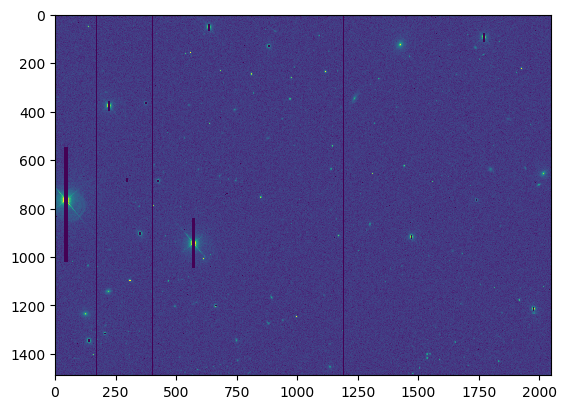

In [5]:
# load SDSS images
dataset = SDSSIO.SDSSDataSet(AccuracyBenchmark.SDSS_DATA_DIR)
sdss_images = SDSSIO.load_field_images(dataset, AccuracyBenchmark.STRIPE82_RCF);
plot_data = AccuracyBenchmark.plot_image(sdss_images[3]);
PyPlot.imshow(plot_data);

## 3. Examine the priors

The prior's parameters are stored in the `Model.prior` object.

In [6]:
fieldnames(Model.prior)

8-element Array{Symbol,1}:
 :is_star           
 :flux_mean         
 :flux_var          
 :k                 
 :color_mean        
 :color_cov         
 :gal_radius_px_mean
 :gal_radius_px_var 

Are stars typially brighter that galaxies?

In [7]:
Model.prior.flux_mean[1] > Model.prior.flux_mean[2]

true

Yes!

How large is the half light radius of a typical galaxy?

In [8]:
exp(Model.prior.gal_radius_px_mean - Model.prior.gal_radius_px_var)

0.7895335881650182

The mode of galaxy radii is 0.7895 SDSS pixels, according to our prior. That's about 0.31 arcseconds.

How many mixture components are in the star color prior?

In [9]:
size(Model.prior.color_mean[:, :, 1])

(4, 8)

There are 8. Each component is a 4-dimensional Gaussian. The galaxy color prior also is a Gaussian mixture model with 8 components:

In [10]:
size(Model.prior.color_mean[:, :, 2])

(4, 8)

## 4. Run variational inference (VI) on the image set

The next block of code takes about 30 minutes single threaded. To enable more threads, before launching Jupyter, set two environment variables:
```
export OMP_NUM_THREADS=1
export JULIA_NUM_THREADS=4
```
The most optimized VI implementation is on the [kf/sparsefun5](https://github.com/jeff-regier/Celeste.jl/tree/kf/sparsefun5) branch -- not this one.

In [ ]:
dummy_box = ParallelRun.BoundingBox(-1000.0, 1000.0, -1000.0, 1000.0)
vi_results = ParallelRun.infer_box(sdss_images, dummy_box; method = :single_vi);

## 5. Run MCMC on the image set

MCMC is parallelized differently (using `pmap`), which requires running an exterior script to schedule a set of jobs.  For the MCMC SDSS Stripe2 experiment script to run, we need a few files to be saved (based on the synthetic catalog and the image pixels generated above).  The following commands will reproduce our experiments

1. Create ground truth files (repeats code above)
 ```
$ cd Celeste.jl/benchmark/accuracy
$ julia write_ground_truth_catalog_csv.jl coadd
$ julia sdss_rcf_to_csv.jl  # DEFAULTS to S82 Field
 ``` 
  which will create a file `sdss_4263_5_119_prediction_<hash>.csv` in the directory `Celeste.jl/benchmark/accuracy/output`. 

2. Run the AIS-MCMC code on each source
  ```
$ cd Celeste.jl/experiments/mcmc_scripts
$ ./run_s82_shards.sh
  ```
  which will schedule jobs for each set of sources and store samples in directory `ais-output-s82`.
 
3. Score results  
```
julia score_mcmc_results.jl --ais-output ais-output-synthetic --output-dir synthetic-results \
  --truth-csv ~/Proj/Celeste.jl/benchmark/accuracy/output/coadd_for_4263_5_119_<hash>.csv \
  --vb-csv ~/Proj/Celeste.jl/benchmark/accuracy/output/sdss_4263_5_119_predictions_<hash>.csv \
  --photo-csv ~/Proj/Celeste.jl/benchmark/accuracy/output/sdss_4263_5_119_primary_<hash>.csv
```
  which saves a bunch of `csv` files to `experiments/mcmc_scripts/s82-results/` needed to reproduce plots (including the prediction score and uncertainty score dataframes that mirror the results below). 

## 6. Score predictions

In [ ]:
celeste_catalog = AccuracyBenchmark.celeste_to_df(vi_results)
prediction_dfs = [primary_catalog, celeste_catalog,]
scores_vi = AccuracyBenchmark.score_predictions(coadd_catalog, prediction_dfs)

## 7. Score uncertainty

In [ ]:
uncertainty_df = AccuracyBenchmark.get_uncertainty_df(coadd_catalog, celeste_catalog)
uq_scores_vi = AccuracyBenchmark.score_uncertainty(uncertainty_df)

In [ ]:
uq_scores_mcmc = CSV.read("mcmc_scripts/s82-results/uscore_mc.csv")

## 8. Plot the results

See `plots.ipynb` for a guide to plotting these results.